# EncoderDecoder Sequence Fibrosis Progression

## 1. Libraries

In [1]:
#########################################################################
# 01. Libraries

import time
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from operator import itemgetter 
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from scipy import ndimage

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

# To allocate memory dynamically
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')
tf.config.experimental.enable_mlir_graph_optimization()

from tensorflow.keras import layers, models, optimizers, regularizers, constraints
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import ResNet50

from Utils.utils import *
from Utils.attention_layers import BahdanauAttention, ScaledDotProductAttention, GeneralAttention

pd.set_option('display.max_colwidth', 1000)

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

#########################################################################

## 2. Global Variables

In [2]:
#########################################################################
# 02. Global Variables

path = '../01_Data/'
path_models = '../05_Saved_Models/'

path_train_masks = path + '/train_masks/'
path_test_masks = path + '/test_masks/'

#########################################################################

## 3. Load Data & Preprocess Data

In [3]:
#########################################################################
# 03. Load Data & Preprocess Data

df_train = pd.read_csv( path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

print(f'1.1 -> There are {df_train.Patient.unique().shape[0]} train unique patients')
print(f'1.2 -> There are {df_test.Patient.unique().shape[0]} test unique patients')

train_mask_paths = glob.glob(path_train_masks + '*')
test_mask_paths = glob.glob(path_test_masks + '*')

print(f'No. of Train Masks : {len(train_mask_paths)}')
print(f'No. of Test Masks : {len(test_mask_paths)}')
      
unique_train_patients = df_train.Patient.unique()
unique_test_patients = df_test.Patient.unique()

dict_train_patients_masks_paths = {patient: path_train_masks + patient + '/' for patient in unique_train_patients}
dict_test_patients_masks_paths = {patient: path_test_masks + patient + '/' for patient in unique_test_patients}

for patient in tqdm(dict_train_patients_masks_paths):
    if os.path.exists(dict_train_patients_masks_paths[patient]):
        list_files = os.listdir(dict_train_patients_masks_paths[patient])
        list_files = [dict_train_patients_masks_paths[patient] + file for file in list_files]
        dict_train_patients_masks_paths[patient] = list_files
    
for patient in tqdm(dict_test_patients_masks_paths):
    list_files = os.listdir(dict_test_patients_masks_paths[patient])
    list_files = [dict_test_patients_masks_paths[patient] + file for file in list_files]
    dict_test_patients_masks_paths[patient] = list_files
    
# Preprocessing:

df_train = df_train.groupby(['Patient', 'Weeks']).agg({
    'FVC': np.mean,
    'Percent': np.mean,
    'Age': np.max,
    'Sex': np.max,
    'SmokingStatus': np.max 
}).reset_index()

# Noramlize fvc

mean_fvc, std_fvc = df_train.FVC.mean(), df_train.FVC.std()
mean_perc, std_perc = df_train.Percent.mean(), df_train.Percent.std()
mean_age, std_age = df_train.Age.min(), df_train.Age.max()

df_train['Age'] = df_train['Age'].apply(lambda x: (x-mean_age)/std_age)
df_test['Age'] = df_test['Age'].apply(lambda x: (x-mean_age)/std_age)

df_train['FVC'] = df_train['FVC'].apply(lambda x: (x-mean_fvc)/std_fvc)
df_test['FVC'] = df_test['FVC'].apply(lambda x: (x-mean_fvc)/std_fvc)

df_train['Percent'] = df_train['Percent'].apply(lambda x: (x-mean_perc)/std_perc)
df_test['Percent'] = df_test['Percent'].apply(lambda x: (x-mean_perc)/std_perc)

# We will consider first week as ct-scan week

df_train['Weeks'] = df_train['Weeks'].apply(lambda x: x if x>=0 else 0)
df_test['Weeks'] = df_test['Weeks'].apply(lambda x: x if x>=0 else 0)

df_train = df_train.sort_values(['Patient', 'Weeks']).reset_index(drop=True)
df_test = df_test.sort_values(['Patient', 'Weeks']).reset_index(drop=True)

df_train['ElapsedWeeks'] = df_train['Weeks']
df_test['ElapsedWeeks'] = df_test['Weeks']

train_weeks_elapsed = df_train.set_index(['Patient', 'Weeks'])['ElapsedWeeks'].diff().reset_index()
test_weeks_elapsed = df_test.set_index(['Patient', 'Weeks'])['ElapsedWeeks'].diff().reset_index()

df_train = df_train.drop('ElapsedWeeks', axis=1)
df_test = df_test.drop('ElapsedWeeks', axis=1)

train_weeks_elapsed['ElapsedWeeks'] = train_weeks_elapsed['ElapsedWeeks'].fillna(0).astype(int)
test_weeks_elapsed['ElapsedWeeks'] = test_weeks_elapsed['ElapsedWeeks'].fillna(0).astype(int)

train_weeks_elapsed['ElapsedWeeks'] = train_weeks_elapsed['ElapsedWeeks'].apply(lambda x: 0 if x<0 else x)
test_weeks_elapsed['ElapsedWeeks'] = test_weeks_elapsed['ElapsedWeeks'].apply(lambda x: 0 if x<0 else x)

df_train = df_train.merge(train_weeks_elapsed, how='inner', on=['Patient', 'Weeks'])
df_test = df_test.merge(test_weeks_elapsed, how='inner', on=['Patient', 'Weeks'])

df_train['patient_row'] = df_train.sort_values(['Patient', 'Weeks'], ascending=[True, True]) \
             .groupby(['Patient']) \
             .cumcount() + 1

df_test['patient_row'] = df_test.sort_values(['Patient', 'Weeks'], ascending=[True, True]) \
             .groupby(['Patient']) \
             .cumcount() + 1


df_train['WeeksSinceLastVisit'] = df_train.apply(lambda x: x['Weeks'] if x['patient_row']==1 else x['ElapsedWeeks'], axis=1)
df_test['WeeksSinceLastVisit'] = df_test.apply(lambda x: x['Weeks'] if x['patient_row']==1 else x['ElapsedWeeks'], axis=1)

# Ini dictionaries

columns = ['FVC', 'Age', 'Sex', 'SmokingStatus', 'WeeksSinceLastVisit', 'Percent']
dict_patients_train_ini_features, dict_patients_test_ini_features = {}, {}
df_train_patients, df_test_patients = df_train.set_index('Patient'), df_test.set_index('Patient')

# Mapping categories dictionaries 
dict_patients = {k: v for k, v in enumerate(unique_train_patients)}
dict_patients_inv = {v: k for k, v in enumerate(unique_train_patients)}

dict_sex = {'Male': 0, 'Female': 1}
dict_sex_inv = {0: 'Male', 1: 'Female'}

dict_smoke = {'Ex-smoker': 0, 'Never smoked': 1, 'Currently smokes': 2}
dict_smoke_inv = {0: 'Ex-smoker', 1:'Never smoked', 2:'Currently smokes'}

df_train_patients.index = df_train_patients.index.to_series().map(dict_patients_inv).values
df_train_patients.Sex = df_train_patients.Sex.apply(lambda x: dict_sex[x])
df_train_patients.SmokingStatus = df_train_patients.SmokingStatus.apply(lambda x: dict_smoke[x])

df_test_patients.index = df_test_patients.index.to_series().map(dict_patients_inv).values
df_test_patients.Sex = df_test_patients.Sex.apply(lambda x: dict_sex[x])
df_test_patients.SmokingStatus = df_test_patients.SmokingStatus.apply(lambda x: dict_smoke[x])

for patient in unique_train_patients:
    dict_patients_train_ini_features[patient] = \
        df_train_patients[columns].loc[dict_patients_inv[patient], :].to_dict('records')[0]
    
for patient in unique_test_patients:
    dict_patients_test_ini_features[patient] = \
        df_test_patients[columns].loc[dict_patients_inv[patient], :].to_dict()

# Decoder inputs
dict_train_sequence_fvc, dict_train_sequence_weekssincelastvisit = {}, {}
for patient in unique_train_patients:
    dict_train_sequence_fvc[patient] = list(df_train_patients['FVC'].loc[dict_patients_inv[patient]].values[1:])
    dict_train_sequence_weekssincelastvisit[patient] = list(df_train_patients['WeeksSinceLastVisit'].loc[dict_patients_inv[patient]].values[1:])

#########################################################################

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5013.51it/s]

1.1 -> There are 176 train unique patients
1.2 -> There are 5 test unique patients
No. of Train Masks : 176
No. of Test Masks : 5


## 4. Data Generator

Similar as `03_Autoencoder` Training Generator but instead of imgs as output we will have the ini features that we will use as our encoder input

In [4]:
#########################################################################

## 04. Data Generator

class SequenceToSequenceDataGenerator(Sequence):
    
    def __init__(self, training, df, dict_ini_features, dict_patients_masks_paths,
                 batch_size=1, num_frames_batch=32, 
                 alpha=1.0, random_window=False, center_crop=True,
                 img_size_load=(500, 500, 3), 
                 img_size_crop=(440, 440, 3)):
        
        super(SequenceToSequenceDataGenerator, self).__init__()
        self.training = training
        self.df = df
        self.dict_ini_features = dict_ini_features
        self.batch_size = batch_size
        self.num_frames_batch = num_frames_batch
        self.alpha = alpha

        self.random_window = random_window
        self.center_crop = center_crop
        self.img_size_load = img_size_load
        self.img_size_crop = img_size_crop
        
        self.dict_patients_masks_paths = dict_patients_masks_paths
        
        self.ids = list(self.df['Patient'].unique())

        self.num_steps = int(np.ceil(len(self.ids) / self.batch_size))
        self.on_epoch_end()
      
    # Number of batches in the sequence
    
    def __len__(self):
        return self.num_steps
    
    
    # Gets the batch at position index, return patient images and dict ini features
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        patient_ids = [self.ids[k] for k in indexes]
        list_scan_imgs = [decodePatientImages(patient, 
                                              self.dict_patients_masks_paths,
                                              image_size=(self.img_size_load[0], self.img_size_load[1]), 
                                              numpy=True) 
                          for patient in patient_ids]
        patient_imgs = self.groupImages(list_scan_imgs)
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        for patient_ in patient_ids:
            self.dict_ini_features[patient_]['Patient'] = patient_
        return (patient_imgs, [self.dict_ini_features[patient_] for patient_ in patient_ids])
    
    # From n patient frames we will only keep self.alpha*n frames, cutting on top and bottom
    
    def filterSlices(self, array_imgs):
        num_patient_slices = array_imgs.shape[0]
        beta = int(self.alpha * num_patient_slices)
        if beta % 2 != 0:
            beta += 1
        if num_patient_slices > self.num_frames_batch:
            if beta > self.num_frames_batch and self.alpha < 1:
                remove = int((num_patient_slices - beta)/2)
                array_imgs = array_imgs[remove:, :, :, :]
                array_imgs = array_imgs[:-remove:, :, :]

        return array_imgs
    
    # Skip frames unniformally according to self.num_frames_batch value
    
    def frameSkipImages(self, patient_imgs):
        num_patient_slices = patient_imgs.shape[0]
        frame_skip = num_patient_slices // self.num_frames_batch
        skipped_patient_imgs = np.zeros((self.num_frames_batch, self.img_size_load[0], self.img_size_load[1], 1))
        for i in range(self.num_frames_batch):
            skipped_patient_imgs[i] = patient_imgs[i*frame_skip]    
        return skipped_patient_imgs
    
    # Select a random window of patient frames, in case its images has more frames than self.num_frame_batch 
    
    def randomWindow(self, patient_imgs):
        windowed_imgs = np.zeros((self.num_frames_batch, patient_imgs.shape[1], patient_imgs.shape[2], 1))
        num_frames = patient_imgs.shape[0]
        if num_frames < self.num_frames_batch:
            windowed_imgs[:num_frames] = patient_imgs
        else:
            random_frames = np.arange(num_frames)
            index = np.random.randint(0, num_frames - self.num_frames_batch)
            windowed_imgs[0:] = patient_imgs[index:index+self.num_frames_batch]
        return windowed_imgs
            
    
    # Convert raw frames to a fix size array -> (batch_size, num_frames_batch, img_size_crop[0], img_size_crop[1], 1)
    
    def groupImages(self, list_scan_imgs):
        grouped_imgs = []
        for patient_imgs in list_scan_imgs:
            if patient_imgs.shape[1] > self.num_frames_batch:
                patient_imgs = self.filterSlices(patient_imgs)
            if self.random_window:
                patient_imgs = self.randomWindow(patient_imgs)
            else:
                patient_imgs = self.frameSkipImages(patient_imgs)
            grouped_imgs.append(patient_imgs)
        return np.asarray(grouped_imgs)
        
    # Performs augmentation operations conserving the 3D property on the z axis
    
    def loadImagesAugmented(self, patient_imgs):

        if self.img_size_load != self.img_size_crop:
            patient_imgs = self.center3Dcropping(patient_imgs)
            if patient_imgs.shape[2] > self.img_size_crop[0] and patient_imgs.shape[3] > self.img_size_crop[1]:
                patient_imgs = self.random3DCropping(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.fliplr(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.flipud(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, :, ::-1]
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, ::-1, :]
        if self.training:
            patient_rotated_imgs= []
            for batch in range(patient_imgs.shape[0]):
                angle = np.random.randint(-15, 15)
                batch_imgs_rotated = np.asarray([ndimage.rotate(patient_imgs[batch, i], angle, order=1,
                                                                reshape=False) for i in range(patient_imgs.shape[1])])
                patient_rotated_imgs.append(batch_imgs_rotated)
            patient_imgs = np.asarray(patient_rotated_imgs) 
        return patient_imgs
    
    
    #Random Cropping 3D - change x, y axis but not z
    
    def random3DCropping(self, patient_imgs):
        w, h = self.img_size_crop[0], self.img_size_crop[1]
        x = np.random.randint(0, patient_imgs.shape[2] - w)
        y = np.random.randint(0, patient_imgs.shape[2] - h)
        patient_crop_imgs = patient_imgs[:, :, y:y+h, x:x+w]
        return patient_crop_imgs
    
    # Center 3D Cropping
    
    def center3Dcropping(self, patient_imgs):
        w, h = patient_imgs.shape[2] - 20, patient_imgs.shape[3] - 20
        img_height, img_width = patient_imgs.shape[2], patient_imgs.shape[3]
        left, right = (img_width - w) / 2, (img_width + w) / 2
        top, bottom = (img_height - h) / 2, (img_height + h) / 2
        left, top = round(max(0, left)), round(max(0, top))
        right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
        patient_crop_imgs = patient_imgs[:, :, top:bottom, left:right]
        return patient_crop_imgs
    
    # We shuffle the data at the end of each epoch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)
     
    # Get only one patient, for debugging or prediction
        
    def getOnePatient(self, patient_id):
        list_scan_imgs = [decodePatientImages(patient_id,
                                              self.dict_patients_masks_paths,
                                              image_size=(self.img_size_load[0], self.img_size_load[1]),
                                              numpy=True)] 
        patient_imgs = self.groupImages(list_scan_imgs)
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        self.dict_ini_features[patient_id]['Patient'] = patient_id
        return (patient_imgs, [self.dict_ini_features[patient_id]])
    
    
#########################################################################

## 5. Models

In [5]:
#########################################################################

## 05. Models

### 05.1 Backbone 3D Image Model

class BackBone3DModel(models.Model):
    
    def __init__(self, unet=False, path_unet=None):
        super(BackBone3DModel, self).__init__(name='BackBone3DModel')
        self.unet = unet
        self.path_unet = path_unet
        if self.unet:
            self.unet_model = tf.keras.models.load_model(self.path_unet, compile=False) 
            self.unet_model.trainable = False
        else:
            self.avg_pool = layers.AvgPool3D(pool_size=(2, 1, 1), name='avg_pool')
            
            self.block1_conv1 = layers.Conv3D(32, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block1_conv1')
            self.block1_conv2 = layers.Conv3D(64, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block1_conv2')
            self.block1_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block1_maxpool1')

            self.block2_conv1 = layers.Conv3D(128, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block2_conv1')
            self.block2_conv2 = layers.Conv3D(128, kernel_size=(3, 3, 3),padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block2_conv2')
            self.block2_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block2_maxpool1')

            self.block3_conv1 = layers.Conv3D(256, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block3_conv1')
            self.block3_conv2 = layers.Conv3D(256, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block3_conv2')
            self.block3_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block3_maxpool1')
            
            self.block4_conv1 = layers.Conv3D(512, kernel_size=(3, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='block3_conv2')
        
    
    def call(self, inputs):
        if self.unet:
            x = self.unet_model(inputs)
            # (None, 2, 20, 20, 256)  
        else:
            x = self.avg_pool(inputs)
            x = self.block1_conv1(x)
            x = self.block1_conv2(x)
            x = self.block1_maxpool1(x)

            x = self.block2_conv1(x)
            x = self.block2_conv2(x)
            x = self.block2_maxpool1(x)

            x = self.block3_conv1(x)
            x = self.block3_conv2(x)
            x = self.block3_maxpool1(x)
            
            x = self.block4_conv1(x)
        
        return x
    

### 05.2 Backbone Tabular Data for Patients metadata

class BackBoneTabularModel(models.Model):
    
    def __init__(self, dense_dim, dropout_rate, sex_dim=20, smoker_dim=20, max_norm=1):
        super(BackBoneTabularModel, self).__init__(name='BackBoneTabularModel')
        
        self.dense_dim = dense_dim
        self.dropout_rate = dropout_rate
 
        self.sex_dim = sex_dim 
        self.smoker_dim = smoker_dim
        
        # Embedding layers
        self.emb_sex = layers.Embedding(input_dim=2, output_dim=self.sex_dim)
        self.emb_smoker = layers.Embedding(input_dim=3, output_dim=self.smoker_dim)
        
        # Output layer
        self.dropout = layers.Dropout(self.dropout_rate)
        self.dense = layers.Dense(units=self.dense_dim, 
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  kernel_constraint = constraints.MaxNorm(max_norm),
                                  name='tabular_dense')
        self.batch_norm = layers.BatchNormalization()
        
        
    def call(self, inputs, training=True):

        patient_sex = self.emb_sex(inputs[:, 0])
        patient_smoke = self.emb_smoker(inputs[:, 1])
        x = tf.concat([patient_sex,
                       patient_smoke,
                       tf.expand_dims(inputs[:, 2], 1), #Age
                       tf.expand_dims(inputs[:, 3], 1)], axis=-1) # Percent
        
        x = self.dropout(x, training)
        x = self.dense(x)
        x = self.batch_norm(x)
        x = tf.nn.relu(x)
        
        return x
        
                      
### 05.3 Encoder Model

class Encoder(models.Model):
    
    def __init__(self, features_dim, dropout_rate=0.2, unet=False, path_unet=None,
                       tabular_dense_dim=16, tabular_dropout_rate=0.4,
                       tabular_sex_dim=10, tabular_smoker_dim=10, max_norm=1, recurrent_max_norm=0.1,
                     **kwargs):
                    
        super(Encoder, self).__init__( **kwargs, name='Encoder')
        self.backbone_img_model = BackBone3DModel(unet, path_unet)
        self.backbone_tabular_model = BackBoneTabularModel(dense_dim=tabular_dense_dim, 
                                                           dropout_rate=tabular_dropout_rate,  
                                                           sex_dim=tabular_sex_dim, 
                                                           smoker_dim=tabular_smoker_dim,
                                                           max_norm=max_norm)
        
        self.dropout = layers.Dropout(dropout_rate, name='dropout')
        self.dense = layers.Dense(features_dim, name='encoder_dense', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_constraint=constraints.MaxNorm(max_norm))
        self.batch_norm2 = layers.BatchNormalization()

    
    def call(self, img_inputs, scalar_inputs, training=True):
        # Image Features from 3D Model
        img_features = self.backbone_img_model(img_inputs)
        img_dim = img_features.shape[1]*img_features.shape[2]*img_features.shape[3]
        img_features = tf.reshape(img_features, tf.convert_to_tensor([img_features.shape[0], 
                                                                     img_dim, 
                                                                     img_features.shape[4]], dtype=tf.int32))
        
        
        # Scalar Features from Patient Metadata
        scalar_features = self.backbone_tabular_model(scalar_inputs, training)
        self.repeatvector = layers.RepeatVector(img_features.shape[1])
        scalar_features = self.repeatvector(scalar_features)
               
        # Mixing both together
        features = tf.concat(values=[img_features, scalar_features], axis=-1)
        features = self.dropout(features, training=training)
        features = self.dense(features)
        feaures = self.batch_norm2(features)
        features = tf.nn.relu(features)
        
        return features
    

### 05.4 Decoder Model

class Decoder(models.Model):
    
    def __init__(self, embedding_dim, rnn_units=[64], dense_units=[64], dense_activation=True,
                 dropout_rate=0.2, max_norm=1, recurrent_max_norm=1,
                 attention='bahdanau', **kwargs):
        super(Decoder, self).__init__(**kwargs, name='Decoder')
        self.rnn_units = rnn_units
        self.dense_units = dense_units
        self.attention_features_shape = self.rnn_units[-1]
        self.dropout_rate = dropout_rate
        self.attention = attention.lower()
        self.max_norm = max_norm
        self.recurrent_max_norm = recurrent_max_norm

        if attention.lower() == 'bahdanau':
            self.attention_layer = BahdanauAttention(self.attention_features_shape)   
        elif attention.lower() == 'dotproduct':
            self.attention_layer = ScaledDotProductAttention(self.attention_features_shape)   
        elif attention.lower() == 'general':
            self.attention_layer = GeneralAttention(self.attention_features_shape)   
        else:
            raise ValueError(f'Attention {attention} not valid. Choose between bahdanau/dotproduct/general.')
            
        self.flatten = layers.Flatten(name='flatten')
        self.dropout = layers.Dropout(self.dropout_rate)
        self.dense_activation = dense_activation
        self.grus = self.stackRNN()
        if self.dense_units:
            self.fcc_denses = self.stackDense()
        
        self.dense_output = layers.Dense(1, activation='linear')
        self.dense_distribution = layers.Dense(2, activation='linear')
        
        self.distribution = tfp.layers.DistributionLambda(
                                lambda t: tfd.Laplace(loc=t[:, 0],
                                                     scale=0.01*tf.math.softplus(t[:, 1])),
                                name='laplace_dist')
    
    def call(self, decoder_input, features, hidden, training=True):
        context_vector, attention_weights = self.attention_layer(features, hidden)
        
        x = tf.concat([tf.expand_dims(context_vector, 1), tf.expand_dims(decoder_input, 1)], axis=-1)
            
        for gru in self.grus[:-1]:
            x = gru(x, training=training)
            
        output, state = self.grus[-1](x, training=training)        
        x = self.flatten(output)
        
        if self.dropout_rate > 0:
            x = self.dropout(x, training=training)
            
        if self.dense_units:
            for fcc in self.fcc_denses:
                x = fcc(x)
        
        x_output = self.dense_output(x)
        
        x_distribution = self.dense_distribution(x)
        x_distribution = self.distribution(x_distribution)
        
        outputs = (x_output, x_distribution)
        
        return outputs, state, attention_weights
    
    def stackRNN(self):
        rnns = []
        for units in self.rnn_units[:-1]:
            gru_ = layers.GRU(units, 
                              return_state=False,
                              return_sequences=True, 
                              kernel_constraint=constraints.MaxNorm(self.max_norm),
                              recurrent_constraint=constraints.MaxNorm(self.recurrent_max_norm),
                              kernel_regularizer=regularizers.l2(1e-4),
                              recurrent_initializer='glorot_uniform')
            rnns.append(gru_)
        
        gru_ = layers.GRU(self.rnn_units[-1], 
                          return_sequences=True, 
                          return_state=True,
                          kernel_constraint=constraints.MaxNorm(self.max_norm),
                          recurrent_constraint=constraints.MaxNorm(self.recurrent_max_norm),
                          kernel_regularizer=regularizers.l2(1e-4),
                          recurrent_initializer='glorot_uniform')
        
        rnns.append(gru_)
        return rnns
    
    
    def stackDense(self):
        denses, batch_norms = [], []
        for units in self.dense_units:
            dense_ = layers.Dense(units,
                                  activation=self.dense_activation,
                                  kernel_constraint=constraints.MaxNorm(self.max_norm),
                                  kernel_regularizer=regularizers.l2(1e-4))
            denses.append(dense_)
        return denses
    
    
    def reset_state(self, batch_size, initial_fvc):
        hidden = tf.repeat([initial_fvc], repeats=[self.rnn_units[0]], axis=0)
        return tf.reshape(hidden, (1, hidden.shape[0]))
        # tf.reshape(p, (1, p.shape[0])).shape
#         return tf.zeros((batch_size, self.rnn_units[0]))


### 05.5 Global Model
    
class PulmonarFibrosisEncoderDecoder(models.Model):
    
    def __init__(self, encoder_tabular_dense_dim, encoder_tabular_dropout_rate, 
                 encoder_tabular_sex_dim, encoder_tabular_smoker_dim, encoder_feature_dim, encoder_unet, encoder_path_unet,
                 encoder_max_norm, encoder_dropout_rate, decoder_embedding_dim, decoder_rnn_units, 
                 decoder_dense_units, decoder_dense_activation, decoder_attention,
                 decoder_dropout_rate, decoder_max_norm, decoder_recurrent_max_norm,
                 learning_rate, clipvalue, checkpoint_path, teacher_forcing, batch_size,
                 learning_rate_epoch_decay, epsilon, epsilon_decay, save_checkpoints, 
                 restore_last_checkpoint, dict_train_sequence_fvc, dict_train_sequence_weekssincelastvisit,
                 dict_train_patients_masks_paths, dict_patients_train_ini_features, mean_fvc, std_fvc,
                 **kwargs):
        
        super(PulmonarFibrosisEncoderDecoder, self).__init__(**kwargs, name='PulmonarFibrosisEncoderDecoder')
        
        tf.keras.backend.clear_session()
        
        # Global dicts
        self.dict_train_sequence_fvc = dict_train_sequence_fvc
        self.dict_train_sequence_weekssincelastvisit = dict_train_sequence_weekssincelastvisit
        self.dict_train_patients_masks_paths = dict_train_patients_masks_paths
        self.dict_patients_train_ini_features = dict_patients_train_ini_features
        
        # Encoder
        self.encoder_tabular_dense_dim = encoder_tabular_dense_dim
        self.encoder_tabular_sex_dim = encoder_tabular_sex_dim
        self.encoder_tabular_smoker_dim = encoder_tabular_smoker_dim
        self.encoder_tabular_dropout_rate = encoder_tabular_dropout_rate
        self.encoder_feature_dim = encoder_feature_dim
        self.encoder_path_unet = encoder_path_unet
        self.unet = encoder_unet
        self.encoder_dropout_rate = encoder_dropout_rate
        self.encoder_max_norm = encoder_max_norm
        
        # Decoder
        self.decoder_embedding_dim = decoder_embedding_dim
        self.decoder_rnn_units = decoder_rnn_units
        self.decoder_dense_units = decoder_dense_units
        self.decoder_dropout_rate = decoder_dropout_rate
        self.decoder_dense_activation = decoder_dense_activation
        self.decoder_attention = decoder_attention
        self.decoder_max_norm = decoder_max_norm
        self.decoder_recurrent_max_norm = decoder_recurrent_max_norm
        
        # Utils - Training 
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.clipvalue = clipvalue
        self.teacher_forcing = teacher_forcing
        self.epsilon = tf.convert_to_tensor(epsilon, dtype=tf.float32)
        self.epsilon_decay = tf.convert_to_tensor(epsilon_decay, dtype=tf.float32)

        # Build model
        self.learning_rate_epoch_decay = learning_rate_epoch_decay
        self.build()
        self.compile()
        
        # Utils
        self.save_checkpoints = save_checkpoints
        self.checkpoint_path = checkpoint_path
        self.buildCheckpoints()
        if restore_last_checkpoint:
            self.ckpt.restore(sorted(self.ckpt_manager.checkpoints)[-1])
        self.mean_fvc=mean_fvc
        self.std_fvc=std_fvc
                
                
    def build(self):
        self.encoder = Encoder(features_dim=self.encoder_feature_dim,
                               tabular_sex_dim=self.encoder_tabular_sex_dim, 
                               tabular_smoker_dim=self.encoder_tabular_smoker_dim,
                               tabular_dense_dim=self.encoder_tabular_dense_dim, 
                               tabular_dropout_rate=self.encoder_tabular_dropout_rate,
                               dropout_rate=self.encoder_dropout_rate, 
                               unet=self.unet, path_unet=self.encoder_path_unet,
                               max_norm=self.encoder_max_norm)
        
        self.decoder = Decoder(embedding_dim=self.decoder_embedding_dim, 
                               rnn_units=self.decoder_rnn_units, 
                               dense_units=self.decoder_dense_units, dropout_rate=self.decoder_dropout_rate,
                               dense_activation=self.decoder_dense_activation,
                               attention=self.decoder_attention, max_norm=self.decoder_max_norm,
                               recurrent_max_norm=self.decoder_recurrent_max_norm)
        
        
    def compile(self):
        super(PulmonarFibrosisEncoderDecoder, self).compile()
            
        self.optimizer = optimizers.Adam(learning_rate=self.learning_rate, clipvalue=self.clipvalue)
        self.loss_function = customLossFunction
        self.metric = [tf.keras.losses.MeanSquaredError(name='mse')]
        
   
    def buildCheckpoints(self):
        if not os.path.exists(self.checkpoint_path):
            os.mkdir(self.checkpoint_path)
            
        self.ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                        decoder=self.decoder,
                                        optimizer=self.optimizer)

        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.checkpoint_path, max_to_keep=10)
                               

    @tf.function
    def trainStep(self, img_tensor, features_tensor, weeks_since_lastvisit_tensor, initial_fvc, target):
        loss, metric = 0, 0
        list_predictions = []
        hidden = self.decoder.reset_state(batch_size=self.batch_size, initial_fvc=initial_fvc[0, 0])
        decoder_input = tf.convert_to_tensor([[initial_fvc[0, 0], weeks_since_lastvisit_tensor[0, 0]]], dtype=np.float32)
        
        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor, 
                                    features_tensor,
                                    training=True)
            for i in range(0, weeks_since_lastvisit_tensor.shape[0]):
                predictions, hidden, _ = self.decoder(decoder_input, 
                                                      features, 
                                                      hidden,
                                                      training=True)
                
                pred_output, pred_distribution = predictions
                pred_std = tf.clip_by_value(pred_distribution.stddev() * 100, 0., 100.)
                pred_mean = pred_distribution.mean()

                loss += self.loss_function(unscale(target[:, i], self.mean_fvc, self.std_fvc),
                                           unscale(pred_mean, self.mean_fvc, self.std_fvc), std=pred_std)
                
                metric += self.metric[0](target[:, i], pred_mean)
                
                # Teacher forcing
                if self.teacher_forcing=='avg':
                    teacher_forc = tf.expand_dims(tf.reduce_mean([target[:, i], pred_mean]), 0)
                elif self.teacher_forcing=='random':
                    random_ = np.random.random()
                    if random_ > 0.5:
                        teacher_forc = target[:, i]
                    else:
                        teacher_forc = pred_mean # pred_output[0]
                else:
                    teacher_forc = (target[:, i] * self.epsilon) + (pred_mean * (1-self.epsilon))
                    
                list_predictions.append(pred_mean)
                if i <= weeks_since_lastvisit_tensor.shape[0]:
                    decoder_input = tf.expand_dims(tf.concat([teacher_forc, weeks_since_lastvisit_tensor[i]], axis=-1), 0)
                
        
        total_loss = (loss/int(len(target)))
        total_metric = (metric/int(len(target)))

        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, total_loss, list_predictions, total_metric
    
    
    def fitModel(self, X_train, X_val=None, epochs=1):
        history = {}
        history['loss'], history['val_loss'], history['metric'] = [], [], []
    
        for epoch in range(0, epochs):
            start = time.time()
            print(f'Epoch [{epoch+1}/{epochs}]')
            len_X_val = 0 if X_val is None else len(X_val)
            len_X_train = len(X_train)
            pbar = tf.keras.utils.Progbar(len_X_train + len_X_val)
            total_loss, total_metric = 0, 0

            # Train
            
            for num_batch, batch in enumerate(X_train):
                img_tensor, features_tensor = batch[0], batch[1]
                patients = [dict_['Patient'] for dict_ in features_tensor]
                target_original = [self.dict_train_sequence_fvc[patient] for patient in patients]
                initial_fvc = [self.dict_patients_train_ini_features[patient]['FVC'] for patient in patients]
                target = tf.convert_to_tensor(target_original, dtype=np.float32)
                features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                         p['SmokingStatus'],
                                                         p['Age'],
                                                         p['Percent']] for p in features_tensor], dtype=tf.float32)
                    
                weeks_since_lastvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_weekssincelastvisit[patient] for patient in patients], 
                                                    dtype=tf.float32)
                weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, 
                                                          [weeks_since_lastvisit_tensor.shape[1], 1])

                batch_loss, batch_loss, list_predictions, batch_metric = self.trainStep(img_tensor, 
                                                                                        features_tensor, 
                                                                                        weeks_since_lastvisit_tensor,
                                                                                        tf.convert_to_tensor([initial_fvc],dtype=tf.float32),
                                                                                        target)
                
                total_loss += batch_loss
                total_metric += batch_metric

                pbar.update(num_batch + 1, values=[('Loss', batch_loss)] + [('mse', batch_metric)])
                
            self.epsilon = self.epsilon * self.epsilon_decay
            total_loss  /= float(len_X_train)
            total_metric  /= float(len_X_train)
            history['loss'].append(total_loss)
            history['metric'].append(total_metric)
            
            # Validation
            if X_val:
                val_total_loss = 0
                for num_batch, batch in enumerate(X_val):
                    img_tensor, features_tensor = batch[0], batch[1]
                    patients = [dict_['Patient'] for dict_ in features_tensor]
                    target_original = [self.dict_train_sequence_fvc[patient] for patient in patients]
                    initial_fvc = [self.dict_patients_train_ini_features[patient]['FVC'] for patient in patients]
                    target = tf.convert_to_tensor(target_original, dtype=np.float32)
                    features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                             p['SmokingStatus'],
                                                             p['Age'],
                                                             p['Percent']] for p in features_tensor], dtype=tf.float32)

                    weeks_since_lastvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_weekssincelastvisit[patient] for patient in patients], 
                                                    dtype=tf.float32)
                    weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, 
                                                          [weeks_since_lastvisit_tensor.shape[1], 1])
                     
                    dict_output_tensors = self.predictStep(img_tensor, 
                                                            features_tensor, 
                                                            weeks_since_lastvisit_tensor, 
                                                            tf.convert_to_tensor([initial_fvc],dtype=tf.float32))
    
                    predictions = dict_output_tensors['predictions']
                    confidences = dict_output_tensors['confidence']
                    val_batch_loss = self.loss_function(unscale(target, self.mean_fvc, self.std_fvc), 
                                                        unscale(predictions, self.mean_fvc, self.std_fvc), 
                                                        std=confidences[:])
                    val_metric = self.metric[0](target, predictions)
                    val_total_loss += val_batch_loss
                    
                    pbar.update(len_X_train + num_batch + 1, values=[('val_loss', val_batch_loss)] + [('val_mse', val_metric)])
                    
                val_total_loss  /= float(len_X_val)
                history['val_loss'].append(val_total_loss)
            
            if self.learning_rate_epoch_decay > 0  and self.learning_rate_epoch_decay < 1:
                self.optimizer.learning_rate = self.optimizer.learning_rate * self.learning_rate_epoch_decay
            X_train.on_epoch_end() 
            if X_val:
                X_val.on_epoch_end()
            if self.save_checkpoints:
                self.ckpt_manager.save()
            print(' ({:.0f} sec)\n'.format( time.time() - start))
            
        return history
    
    
    @tf.function
    def predictStep(self, img_tensor, features_tensor, weeks_since_lastvisit_tensor, initial_fvc):
        
        output_tensors = {}
        list_predictions, list_condidences = [], []
        hidden = self.decoder.reset_state(batch_size=1, initial_fvc=initial_fvc[0, 0])
        decoder_input = tf.convert_to_tensor([[initial_fvc[0, 0], weeks_since_lastvisit_tensor[0, 0]]], dtype=tf.float32)

        encoder_features_tensor = self.encoder(img_tensor, 
                                               features_tensor,
                                               training=False)
        attention_plot = []
        for i in range(0, weeks_since_lastvisit_tensor.shape[0]):
            predictions, hidden, attention_weights = self.decoder(decoder_input, 
                                                                  encoder_features_tensor, 
                                                                  hidden,
                                                                  training=False)
            pred_output, pred_distribution = predictions
            pred_std = tf.clip_by_value(pred_distribution.stddev() * 100, 0., 100.)
            pred_mean = pred_distribution.mean()
                            
            attention_plot.append(tf.reshape(attention_weights, (-1, ))) 
            list_predictions.append(pred_mean)
            list_condidences.append(pred_std)
            
            if i <= weeks_since_lastvisit_tensor.shape[0]:
                decoder_input = tf.expand_dims(tf.concat(values=[pred_mean,
                                                                 weeks_since_lastvisit_tensor[i]], axis=-1), 0)    
    
            
        output_tensors['predictions'] = tf.convert_to_tensor(list_predictions, dtype=tf.float32)
        confidences_tensor = tf.convert_to_tensor(list_condidences, dtype=tf.float32)
        output_tensors['confidence'] = tf.reshape(confidences_tensor, (confidences_tensor.shape[0],
                                                                       confidences_tensor.shape[1]))
        output_tensors['attention_plot'] = tf.convert_to_tensor(attention_plot, dtype=tf.float32)

        return output_tensors
    
        
    def predictEvaluateModel(self, X_generator, patient, initial_fvc, list_weeks_elapsed, batch=None):

        if not batch:
            batch = X_generator.getOnePatient(patient)
        img_tensor, features_tensor = batch[0], batch[1]
        
        features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                 p['SmokingStatus'],
                                                 p['Age'],
                                                 p['Percent']] for p in features_tensor], dtype=tf.float32)
        
        weeks_since_lastvisit_tensor = tf.convert_to_tensor([list_weeks_elapsed], dtype=tf.float32)
        weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, [weeks_since_lastvisit_tensor.shape[1], 1])
        initial_fvc = [self.dict_train_sequence_fvc[patient][0]]
         
        dict_output_tensors = self.predictStep(img_tensor, 
                                                features_tensor, 
                                                weeks_since_lastvisit_tensor, 
                                                tf.convert_to_tensor([initial_fvc], dtype=tf.float32))
        
        list_predictions, attention_plot = dict_output_tensors['predictions'], dict_output_tensors['attention_plot']
        list_confidences = dict_output_tensors['confidence']
        attention_plot = attention_plot[:len(list_predictions)]
        
        return np.asarray(list_predictions),  np.asarray(list_confidences), np.asarray(attention_plot)
    
           
#########################################################################

---

## 6. Model Training

In [8]:
model_inputs = dict(
    # Encoder
    encoder_tabular_dense_dim=32, 
    encoder_tabular_dropout_rate=0.4,
    encoder_tabular_sex_dim=20, 
    encoder_tabular_smoker_dim=20,
    encoder_feature_dim = 256,
    encoder_unet=True,
    encoder_path_unet=path_models + 'encoder_unet3d.h5',
    encoder_dropout_rate=0.4,
    encoder_max_norm=0.1,
    # Decoder
    decoder_embedding_dim = 256, 
    decoder_rnn_units = [256], 
    decoder_dense_units = [],
    decoder_dense_activation=None,
    decoder_dropout_rate = 0.4,
    decoder_max_norm=0.1,
    decoder_recurrent_max_norm=0.1,
    decoder_attention = 'bahdanau',
    # Training
    learning_rate = 2e-4,
    clipvalue=0.5,
    teacher_forcing = 'decay', # avg/random/decay
    batch_size=1, 
    epsilon=1.0, 
    epsilon_decay=1.0,
    # Utils
    learning_rate_epoch_decay=0.9,
    checkpoint_path=path_models + 'checkpoints_gpu/',
    save_checkpoints=False,
    restore_last_checkpoint=False, #True if you want to load last execution weights.
    # Data Handlers
    mean_fvc=mean_fvc,
    std_fvc=std_fvc,
    dict_train_sequence_fvc=dict_train_sequence_fvc,
    dict_train_sequence_weekssincelastvisit=dict_train_sequence_weekssincelastvisit,
    dict_train_patients_masks_paths=dict_train_patients_masks_paths,
    dict_patients_train_ini_features=dict_patients_train_ini_features
)


In [9]:
#########################################################################

img_size_load=(200, 200, 1)
img_size_crop=(160, 160, 1)
num_frames_batch = 32
train_alpha = 0.9
val_alpha = 0.8
batch_size = 1

df_X_train, df_X_val = getTrainValidation(df_train, df_test)

X_train_generator = SequenceToSequenceDataGenerator(training=True, df=df_X_train,
                                                    batch_size=batch_size, num_frames_batch=num_frames_batch, 
                                                    alpha=train_alpha, random_window=True, center_crop=True,
                                                    img_size_load=img_size_load, img_size_crop=img_size_crop,
                                                    dict_ini_features=dict_patients_train_ini_features, 
                                                    dict_patients_masks_paths=dict_train_patients_masks_paths)

X_val_generator = SequenceToSequenceDataGenerator(training=False, df=df_X_val,
                                                  batch_size=1, num_frames_batch=num_frames_batch, 
                                                  alpha=val_alpha, random_window=True, center_crop=True,
                                                  img_size_load=img_size_load, img_size_crop=img_size_crop,
                                                  dict_ini_features=dict_patients_train_ini_features, 
                                                  dict_patients_masks_paths=dict_test_patients_masks_paths)

model = PulmonarFibrosisEncoderDecoder(**model_inputs)

history = model.fitModel(X_train=X_train_generator, 
                         X_val=X_val_generator, 
                         epochs=5)

plotTrainHistory(history, title='Sequence to Sequence Training', scale=True)

#########################################################################

---

## 7. Evaluation & Interpretability

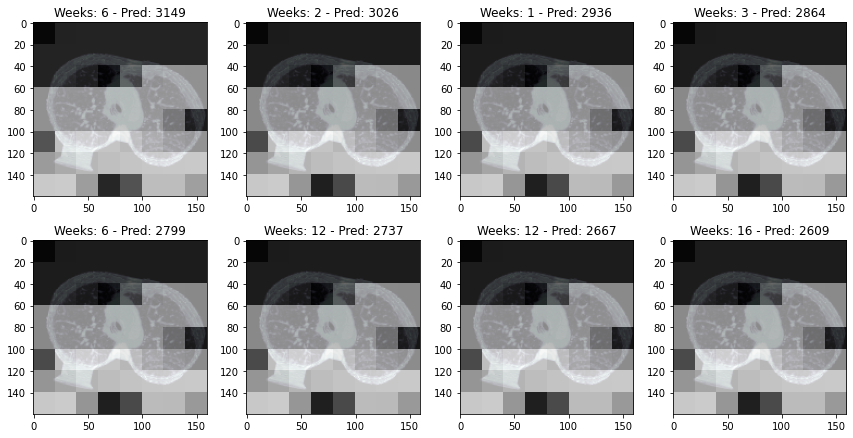

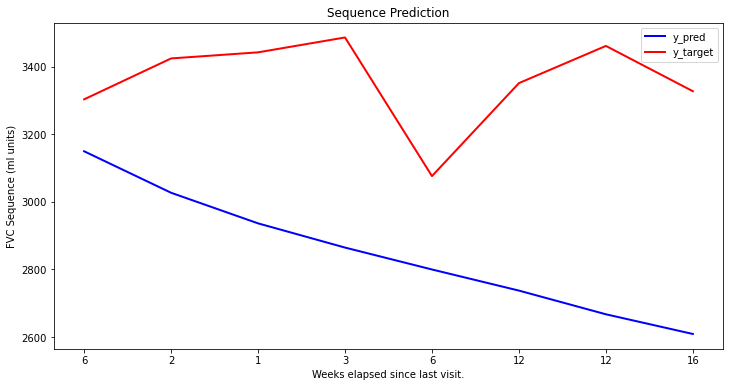

In [12]:
#########################################################################

def plotAttention(images, list_weeks_elapsed, result, attention_plot, alpha=0.7, max_imgs=False):
        
        fig = plt.figure(figsize=(12, 12))
        if max_imgs:
            temp_image = np.max(images, axis=0)
        len_result = len(result)
        for i in range(len_result):
            if not max_imgs:
                temp_image = images[i]
            temp_att = np.resize(attention_plot[i], (8, 8))
            if len_result >= 2:
                ax = fig.add_subplot(len_result//2, len_result//2, i+1)
            else:
                ax = fig.add_subplot(1, 1, 1)
            ax.set_title(f'Weeks: {list_weeks_elapsed[i]} - Pred: {int(result[i])}')
            img = ax.imshow(temp_image, cmap=plt.cm.bone)
            ax.imshow(temp_att, cmap='gray', alpha=alpha, extent=img.get_extent())

        plt.tight_layout()
        plt.show()

        
patient = np.random.choice(unique_train_patients)
# patient = 'ID00419637202311204720264'
batch = X_train_generator.getOnePatient(patient)
list_weeks_elapsed = list(dict_train_sequence_weekssincelastvisit[patient])
result, _, attention_plot = model.predictEvaluateModel(X_generator=None,
                                                      batch=batch,
                                                      patient=patient, 
                                                      list_weeks_elapsed=list_weeks_elapsed, 
                                                      initial_fvc=scale(3000, mean_fvc, std_fvc))#dict_patients_train_ini_features[patient]['FVC'])

patient_imgs = batch[0]
plotAttention(patient_imgs[0].squeeze(), list_weeks_elapsed, 
              unscale(result, mean_fvc, std_fvc), attention_plot, alpha=0.8, max_imgs=True)
plotSequencePrediction(unscale(result, mean_fvc, std_fvc),
                       unscale(np.array(dict_train_sequence_fvc[patient]), mean_fvc, std_fvc), 
                       list_weeks_elapsed)

#########################################################################

---

## 8. Baselines

- 1. **Mean FVC** from training to all predictions.
- 2. **Initial FVC per Patient** from each patient we take initial fvc and predict it over all timesteps.
- 3. **Last timestep** (Although this is a good baseline for general Sequence-to-Sequence purposes it is not for this case because we want to focus on the prognosis availability of the model).

### Baseline 1- Mean FVC

In [ ]:
#########################################################################
# Predict always the train FVC mean

test_patients = list(df_test['Patient'].unique())
dict_predictions = {
    'Patient': [],
    'target': [],
    'prediction': []
}

global_train_mean_fvc = df_X_train.FVC.mean()

for i, patient in enumerate(test_patients):
    subset = df_train[df_train['Patient']==patient]
    list_weeks_elapsed = dict_train_sequence_weekssincelastvisit[patient]
    list_fvc_sequence = np.array(dict_train_sequence_fvc[patient])
    
    list_pred = list_fvc_sequence.copy()
    list_pred[:] = global_train_mean_fvc
    
    dict_predictions['Patient'].append(patient)
    dict_predictions['target'].append(unscale(list_fvc_sequence, mean_fvc, std_fvc).astype(int))
    dict_predictions['prediction'].append(unscale(list_pred, mean_fvc, std_fvc).astype(int))

df_base = pd.DataFrame({'Target': dict_predictions['target'], 
                        'Pred': dict_predictions['prediction']}, 
                       index=[dict_predictions['Patient']])

df_base['mse'] = df_base.apply(lambda x: np.mean((abs(np.array(x['Target']) - x['Pred'])**2)) ,axis=1)
df_base['rmse'] = df_base.apply(lambda x: np.sqrt(np.mean(abs(np.array(x['Target']) - x['Pred']))) ,axis=1)
df_base['mape'] = df_base.apply(lambda x: 100.0 * np.mean(abs((np.array(x['Target']) - x['Pred'])/np.array(x['Target']))),axis=1)
df_base['metric'] = df_base.apply(lambda x: np.mean([customLossFunction(x['Target'][i], 
                                                                        x['Pred'][i]).numpy() 
                                                     for i in range(len(x['Pred']))]),
                                  axis=1)
print('==='*20)
print('Metrics: ')
print(f"MSE: {np.mean(df_base['mse'])} - RMSE: {np.mean(df_base['rmse'])} - MAPE: {np.mean(df_base['mape'])}")
print(f"CustomMetric: {np.mean(df_base['metric'])}")

df_base

#########################################################################

### Baseline 2 - Initial FVC per Patient

In [ ]:
#########################################################################
# Predict always last Timestep

test_patients = list(df_test['Patient'].unique())
dict_predictions = {
    'Patient': [],
    'target': [],
    'prediction': []
}

for patient in test_patients:
    subset = df_train[df_train['Patient']==patient]
    list_weeks_elapsed = dict_train_sequence_weekssincelastvisit[patient]
    list_fvc_sequence = np.array(dict_train_sequence_fvc[patient])
    
    predictions = np.empty(list_fvc_sequence.shape)
    predictions[0:] = dict_patients_train_ini_features[patient]['FVC']
    
    dict_predictions['Patient'].append(patient)
    dict_predictions['target'].append(unscale(list_fvc_sequence, mean_fvc, std_fvc).astype(int))
    dict_predictions['prediction'].append(unscale(predictions, mean_fvc, std_fvc).astype(int))
    

df_base = pd.DataFrame({'Target': dict_predictions['target'], 
                        'Pred': dict_predictions['prediction']}, 
                       index=[dict_predictions['Patient']])

df_base['mse'] = df_base.apply(lambda x: np.mean((abs(np.array(x['Target']) - x['Pred'])**2)) ,axis=1)
df_base['rmse'] = df_base.apply(lambda x: np.sqrt(np.mean(abs(np.array(x['Target']) - x['Pred']))) ,axis=1)
df_base['mape'] = df_base.apply(lambda x: 100.0 * np.mean(abs((np.array(x['Target']) - x['Pred'])/np.array(x['Target']))),axis=1)
df_base['metric'] = df_base.apply(lambda x: np.mean([customLossFunction(x['Target'][i], 
                                                                        x['Pred'][i]).numpy() 
                                                     for i in range(len(x['Pred']))]),
                                  axis=1)
print('==='*20)
print('Metrics: ')
print(f"MSE: {np.mean(df_base['mse'])} - RMSE: {np.mean(df_base['rmse'])} - MAPE: {np.mean(df_base['mape'])}")
print(f"CustomMetric: {np.mean(df_base['metric'])}")
df_base

#########################################################################

### Baseline 3 - Last Timestep

In [ ]:
#########################################################################
# Predict always initial FVC

test_patients = list(df_test['Patient'].unique())
dict_predictions = {
    'Patient': [],
    'target': [],
    'prediction': []
}

for patient in test_patients:
    subset = df_train[df_train['Patient']==patient]
    list_weeks_elapsed = dict_train_sequence_weekssincelastvisit[patient]
    list_fvc_sequence = np.array(dict_train_sequence_fvc[patient])
    
    list_pred = np.empty(list_fvc_sequence.shape)
    list_pred[0] = dict_patients_train_ini_features[patient]['FVC']
    list_pred[1:] = list_fvc_sequence[0:-1]
    
    dict_predictions['Patient'].append(patient)
    dict_predictions['target'].append(unscale(list_fvc_sequence, mean_fvc, std_fvc).astype(int))
    dict_predictions['prediction'].append(unscale(list_pred, mean_fvc, std_fvc).astype(int))
    

df_base = pd.DataFrame({'Target': dict_predictions['target'], 
                        'Pred': dict_predictions['prediction']}, 
                       index=[dict_predictions['Patient']])

df_base['mse'] = df_base.apply(lambda x: np.mean((abs(np.array(x['Target']) - x['Pred'])**2)) ,axis=1)
df_base['rmse'] = df_base.apply(lambda x: np.sqrt(np.mean(abs(np.array(x['Target']) - x['Pred']))) ,axis=1)
df_base['mape'] = df_base.apply(lambda x: 100.0 * np.mean(abs((np.array(x['Target']) - x['Pred'])/np.array(x['Target']))),axis=1)
df_base['metric'] = df_base.apply(lambda x: np.mean([customLossFunction(x['Target'][i], 
                                                                        x['Pred'][i]).numpy() 
                                                     for i in range(len(x['Pred']))]),
                                  axis=1)
print('==='*20)
print('Metrics: ')
print(f"MSE: {np.mean(df_base['mse'])} - RMSE: {np.mean(df_base['rmse'])} - MAPE: {np.mean(df_base['mape'])}")
print(f"CustomMetric: {np.mean(df_base['metric'])}")
df_base

#########################################################################

### Model Metrics

In [ ]:
#########################################################################
# Model Prediction

test_patients = list(df_test['Patient'].unique())
dict_predictions = {
    'Patient': [],
    'target': [],
    'prediction': [],
    'confidences' : []
}

for patient in test_patients:
    subset = df_train[df_train['Patient']==patient]
    list_weeks_elapsed = dict_train_sequence_weekssincelastvisit[patient]# list(subset['Weeks'].values)
    list_fvc_sequence = np.array(dict_train_sequence_fvc[patient])#subset['FVC'].values
    
    result, stds, _ = model.predictEvaluateModel(X_val_generator,
                                            patient=patient, 
                                            list_weeks_elapsed=list_weeks_elapsed, 
                                            initial_fvc=dict_patients_train_ini_features[patient])
    
    predictions, confidences = np.empty(len(list_fvc_sequence)+1), np.empty(len(list_fvc_sequence)+1)
    targets = np.empty(len(list_fvc_sequence)+1)
    predictions[0], confidences[0] = dict_patients_train_ini_features[patient]['FVC'], 100.0
    targets[0] = dict_patients_train_ini_features[patient]['FVC']
    predictions[1:] = result.flatten()
    confidences[1:] = np.clip(stds.flatten() * 100, 0.0, 100.0)
    targets[1:] = list_fvc_sequence
    
    dict_predictions['Patient'].append(patient)
    dict_predictions['target'].append(unscale(targets, mean_fvc, std_fvc).astype(int))
    dict_predictions['prediction'].append(unscale(predictions, mean_fvc, std_fvc).astype(int))
    dict_predictions['confidences'].append(confidences)
    
    df_metrics = pd.DataFrame({'Target': dict_predictions['target'], 
                               'Pred': dict_predictions['prediction'],
                               'Confidences' :dict_predictions['confidences']}, 
                                index=[dict_predictions['Patient']])
    

df_metrics['mse'] = df_metrics.apply(lambda x: np.mean((x['Target'] - x['Pred'])**2), axis=1)
df_metrics['rmse'] = df_metrics.apply(lambda x: np.sqrt(np.mean(abs(x['Target'] - x['Pred']))) ,axis=1)
df_metrics['mape'] = df_metrics.apply(lambda x: 100.0 * np.mean(abs((x['Target'] - x['Pred'])/x['Target'])),axis=1)
df_metrics['metric'] = df_metrics.apply(lambda x: np.mean([customLossFunction(x['Target'][i], 
                                                                              x['Pred'][i],
                                                                              std=x['Confidences'][i]).numpy() 
                                                           for i in range(len(x['Pred']))]),
                                  axis=1)

print('==='*20)
print('Metrics: ')
print(f"MSE: {np.mean(df_metrics['mse'])} - RMSE: {np.mean(df_metrics['rmse'])} - MAPE: {np.mean(df_metrics['mape'])}")
print(f"CustomMetric: {np.mean(df_metrics['metric'])}")
df_metrics

#########################################################################

---

## 9. Conclusions  

- The Sequence to Sequence is able to forecast long sequences and dynamic, one of the biggest challenges on inference stage is the wide range of week a patient can attend the doctor.

- What can the model do that a baseline can not? 
    - Offer good forecasts for **long time fvc measurements** with accurate results, without depending of a fix windowing time visits.

    - **Interpret how the CT-Scan is affecting the forecasts.** Many linear/gradient models can exploit linear relationships between patients metadata and the elapsed time between visits with FVC measure, but our model is using CT-Scan features along with metadata to perform reliable and confident results that can answer questions and not only make forecasts. 
    
- Regularitzation and Data Augmentation is strongly important due to the lack of data we have in our dataset.